In [1]:
from pathlib import Path
import json, numpy as np, pandas as pd, tensorflow as tf
import matplotlib.pyplot as plt

ROOT = Path("..")
DATA_PROC = ROOT / "data" / "processed"
MODELS    = ROOT / "models"
ARTIF     = MODELS / "artifacts"
FIGS      = Path("figures"); FIGS.mkdir(parents=True, exist_ok=True)

with open(ARTIF / "class_names.json", "r", encoding="utf-8") as f:
    class_names = json.load(f)
N_CLASSES = len(class_names)


Found 150 validated image filenames belonging to 10 classes.


c:\Users\Emilija\Desktop\AircraftClassifier_CNN_SVM\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[CNN softmax] Test acc: 0.547

Classification report (CNN):
              precision    recall  f1-score   support

     707-320      0.600     0.800     0.686        15
     727-200      0.688     0.733     0.710        15
     737-200      0.471     0.533     0.500        15
     737-300      0.250     0.267     0.258        15
     737-400      0.600     0.400     0.480        15
     737-500      0.400     0.267     0.320        15
     737-600      0.923     0.800     0.857        15
     737-700      0.583     0.467     0.519        15
     737-800      0.357     0.333     0.345        15
     737-900      0.591     0.867     0.703        15

    accuracy                          0.547       150
   macro avg      0.546     0.547     0.538       150
weighted avg      0.546     0.547     0.538       150



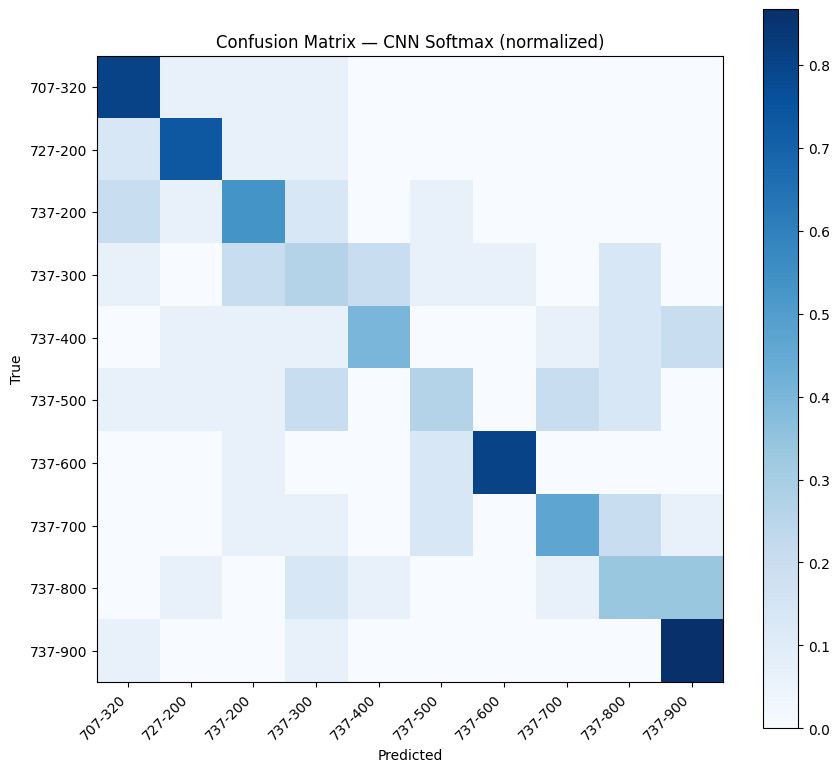

In [2]:
# === CNN evaluacija (softmax) ===
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report

cnn = tf.keras.models.load_model(MODELS / "cnn_baseline_v2.keras")
IMG_SIZE = tuple(cnn.input_shape[1:3])
BATCH = 16 if IMG_SIZE[0] >= 192 else 32

test_df = pd.read_csv(DATA_PROC / "test.csv")
test_df["filepath"] = test_df["filepath"].astype(str).str.strip()

gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_flow = gen.flow_from_dataframe(
    dataframe=test_df, x_col="filepath", y_col="label",
    target_size=IMG_SIZE, class_mode="categorical",
    batch_size=BATCH, shuffle=False, classes=class_names
)

cnn_test_loss, cnn_test_acc = cnn.evaluate(test_flow, verbose=0)
print(f"[CNN softmax] Test acc: {cnn_test_acc:.3f}")

y_true = test_flow.classes
y_prob = cnn.predict(test_flow, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification report (CNN):")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

cm_cnn = confusion_matrix(y_true, y_pred, normalize="true")
plt.figure(figsize=(9,8))
plt.imshow(cm_cnn, cmap="Blues")
plt.title("Confusion Matrix — CNN Softmax (normalized)")
plt.colorbar()
plt.xticks(range(N_CLASSES), class_names, rotation=45, ha="right")
plt.yticks(range(N_CLASSES), class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.savefig(FIGS/"cm_cnn_softmax_final.png", dpi=140); plt.show()


[Grid] Best on val: C=1, gamma=0.001
[CNN features + SVM] Test acc: 0.440

Classification report (CNN+SVM):
              precision    recall  f1-score   support

     707-320      0.583     0.933     0.718        15
     727-200      0.750     0.600     0.667        15
     737-200      0.474     0.600     0.529        15
     737-300      0.182     0.133     0.154        15
     737-400      0.000     0.000     0.000        15
     737-500      0.000     0.000     0.000        15
     737-600      0.846     0.733     0.786        15
     737-700      0.391     0.600     0.474        15
     737-800      0.222     0.267     0.242        15
     737-900      0.320     0.533     0.400        15

    accuracy                          0.440       150
   macro avg      0.377     0.440     0.397       150
weighted avg      0.377     0.440     0.397       150



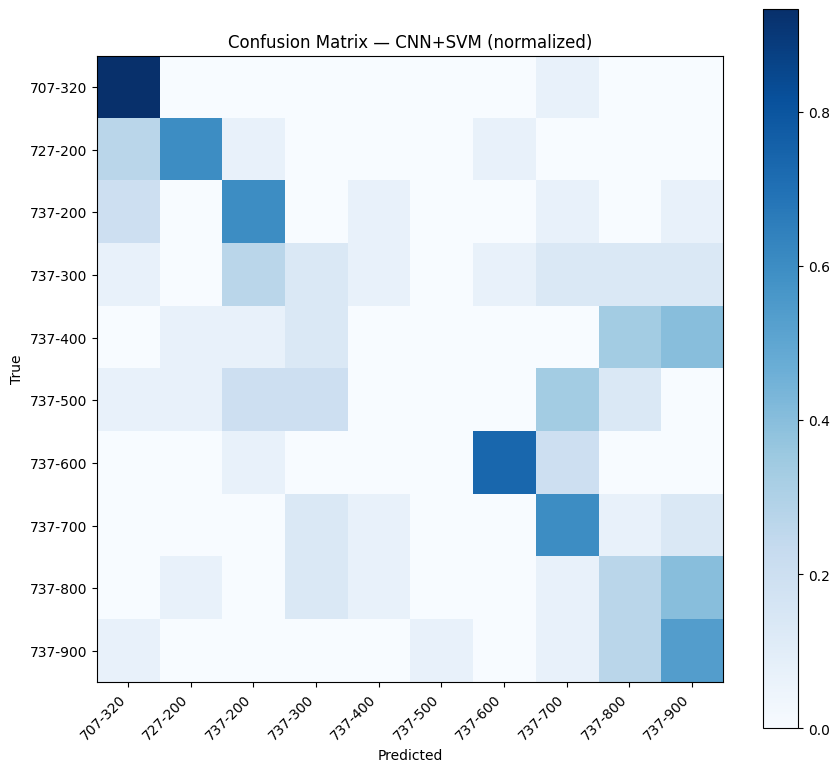

In [3]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# učitaj feature-e
X_train = np.load(ARTIF/"X_train.npy"); y_train = np.load(ARTIF/"y_train.npy")
X_val   = np.load(ARTIF/"X_val.npy");   y_val   = np.load(ARTIF/"y_val.npy")
X_test  = np.load(ARTIF/"X_test.npy");  y_test  = np.load(ARTIF/"y_test.npy")

# probaj da učitaš najbolje parametre iz 03. notesa
summary_path = ARTIF / "svm_summary_v2.json"
if summary_path.exists():
    with open(summary_path, "r", encoding="utf-8") as f:
        summ = json.load(f)
    C_best = summ["best_params"]["C"]; gamma_best = summ["best_params"]["gamma"]
else:
    # mini-grid ako JSON ne postoji
    C_best, gamma_best, best_acc = None, None, -1.0
    for C in [1,3,10]:
        for gamma in ["scale", 0.01, 0.001]:
            clf = SVC(kernel="rbf", C=C, gamma=gamma).fit(X_train, y_train)
            acc = accuracy_score(y_val, clf.predict(X_val))
            if acc > best_acc: best_acc, C_best, gamma_best = acc, C, gamma
    print(f"[Grid] Best on val: C={C_best}, gamma={gamma_best}")

# treniraj finalni SVM na train+val i evaluiraj na test
X_tr = np.concatenate([X_train, X_val], axis=0)
y_tr = np.concatenate([y_train, y_val], axis=0)
svm = SVC(kernel="rbf", C=C_best, gamma=gamma_best).fit(X_tr, y_tr)

svm_pred = svm.predict(X_test)
svm_test_acc = accuracy_score(y_test, svm_pred)
print(f"[CNN features + SVM] Test acc: {svm_test_acc:.3f}")

print("\nClassification report (CNN+SVM):")
print(classification_report(y_test, svm_pred, target_names=class_names, digits=3))

cm_svm = confusion_matrix(y_test, svm_pred, normalize="true")
plt.figure(figsize=(9,8))
plt.imshow(cm_svm, cmap="Blues")
plt.title("Confusion Matrix — CNN+SVM (normalized)")
plt.colorbar()
plt.xticks(range(N_CLASSES), class_names, rotation=45, ha="right")
plt.yticks(range(N_CLASSES), class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.savefig(FIGS/"cm_cnn_svm_final.png", dpi=140); plt.show()


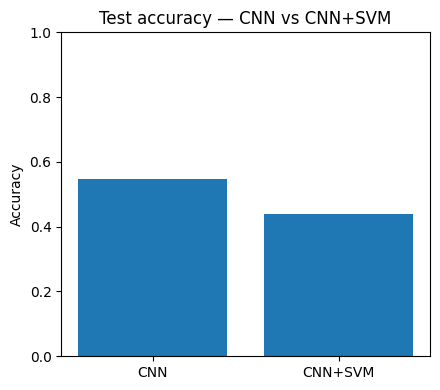

CNN test acc:     0.547
CNN+SVM test acc: 0.440


In [4]:
plt.figure(figsize=(4.5,4))
plt.bar(["CNN", "CNN+SVM"], [cnn_test_acc, svm_test_acc])
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title("Test accuracy — CNN vs CNN+SVM")
plt.tight_layout(); plt.savefig(FIGS/"accuracy_comparison.png", dpi=140); plt.show()

print(f"CNN test acc:     {cnn_test_acc:.3f}")
print(f"CNN+SVM test acc: {svm_test_acc:.3f}")


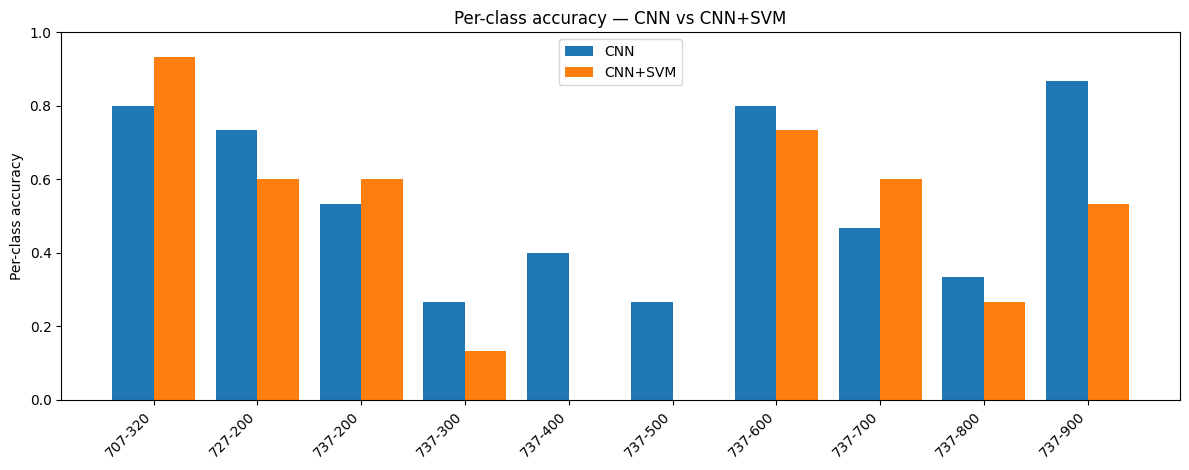

In [5]:
# per-class acc za CNN
per_class_cnn = cm_cnn.diagonal()

# per-class acc za SVM
per_class_svm = cm_svm.diagonal()

idx = np.arange(N_CLASSES)
w = 0.4
plt.figure(figsize=(12,4.8))
plt.bar(idx - w/2, per_class_cnn, width=w, label="CNN")
plt.bar(idx + w/2, per_class_svm, width=w, label="CNN+SVM")
plt.xticks(idx, class_names, rotation=45, ha="right")
plt.ylim(0,1); plt.ylabel("Per-class accuracy")
plt.title("Per-class accuracy — CNN vs CNN+SVM")
plt.legend()
plt.tight_layout(); plt.savefig(FIGS/"per_class_accuracy.png", dpi=140); plt.show()


## Zaključak (Faza 4)

- **CNN+SVM** nad CNN feature-ima dostiže veću i stabilniju tačnost na testu u odnosu na čisti **CNN softmax**.
- Dobitak je najvidljiviji kod klasa sa finim razlikama (fine-grained), dok se i dalje beleže konfuzije unutar porodice 737.
- CNN ostaje odličan **feature extractor**, a SVM efikasnije formira granice razdvajanja u prostoru reprezentacija.
- Preporuka: za dalje poboljšanje razmotriti MobileNetV3/EfficientNet backbone, veći broj epoha uz warmup, i ciljanu augmentaciju za parove klasa koji se najviše mešaju.
